# Import du fichier d'exemples


In [0]:
def get_raw_data_go():
    ''' Returns the set of samples from the local file or download it if it does not exists'''
    import gzip, os.path
    import json

    raw_samples_file = "samples-9x9.json.gz"

    if not os.path.isfile(raw_samples_file):
        print("File", raw_samples_file, "not found, I am downloading it...", end="")
        import urllib.request 
        urllib.request.urlretrieve ("https://www.labri.fr/perso/lsimon/ia-inge2/samples-9x9.json.gz", raw_samples_file)
        print(" Done")

    with gzip.open(raw_samples_file) as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

In [0]:
data = get_raw_data_go()
print("We have", len(data),"examples")

We have 41563 examples


# First steps: transform all the data into numpy arrays to feed your neural network



In [0]:
import numpy as np

def name_to_coord(s):
    assert s != "PASS"
    indexLetters = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'J':8}

    col = indexLetters[s[0]]
    lin = int(s[1:]) - 1
    return col, lin

Pour encoder la carte afin de pouvoir l'utiliser comme vecteur d'entrée pour alimenter notre réseau neuronal, nous avons implémenté trois encodeurs:
- data_transform: Plan noir et plan blanc,c'est mis a 1 si le premier plan a des pierres noires, c'est mis a 1 si le deuxième plan a des pierres blanches, nous avons ajouté un troisième plan pour prendre en compte le joueur suivant par rapport aux autres joueurs.

Pour enrichir notre jeu de données avec toutes les symétries et rotations, l'encodeur ne code pas uniquement le jeu de données d'origine mais il génère également toutes les symétries en utilisant numpy.rot90 () et numpy.flipud ().

In [0]:
def data_transform(data):
    """take as an input the json file and returns two arrays
    the frist array is the board state and the second array 
    is the probabilities that black wins
    """
    X = []
    Y = []
    for d in data: 
        black_stones = np.zeros((9,9), dtype=np.float32)
        white_stones = np.zeros((9,9), dtype=np.float32)
        player_turn = np.zeros((9,9), dtype=np.float32)
        black = d["black_stones"]
        white = d["white_stones"]
        
        for j in range(len(black)):
            x,y = name_to_coord(black[j])
            black_stones[x,y] = 1
        for j in range(len(white)):
            x,y = name_to_coord(white[j])
            white_stones[x,y] = 1
        if (len(d["list_of_moves"])%2 == 0):
          # black turn 1, white turn 0
          player_turn = np.ones((9,9), dtype=np.float32)
        img = np.dstack((black_stones,white_stones,player_turn))
        X.append(img)
        Y.append(d["black_wins"]/d["rollouts"])
        
        X.append(np.rot90(img, k=1, axes=(0,1)))
        Y.append(d["black_wins"]/d["rollouts"])
        
        X.append(np.rot90(img, k=2, axes=(0,1)))
        Y.append(d["black_wins"]/d["rollouts"])
        
        X.append(np.rot90(img, k=3, axes=(0,1)))
        Y.append(d["black_wins"]/d["rollouts"])
        
        img = np.flipud(img)
        X.append(img)
        Y.append(d["black_wins"]/d["rollouts"])
        
        X.append(np.rot90(img, k=1, axes=(0,1)))
        Y.append(d["black_wins"]/d["rollouts"])
        
        X.append(np.rot90(img, k=2, axes=(0,1)))
        Y.append(d["black_wins"]/d["rollouts"])
        
        X.append(np.rot90(img, k=3, axes=(0,1)))
        Y.append(d["black_wins"]/d["rollouts"])
        
    X_data = np.array(X)
    Y_data = np.array(Y)
    return X_data, Y_data

In [0]:
X_data, Y_data = data_transform(data)

(332504, 9, 9, 3)
(332504,)


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train =Y_train.astype('float32')
Y_test = Y_test.astype('float32')
print(X_train.shape)
print(X_test.shape)

(299253, 9, 9, 3)
(33251, 9, 9, 3)


# Second steps: build your neural network and train it


Nous avons ajouté l'attribut padding Afin de ne pas réduire la taille de l'image car nous ne voulons pas ignorer les pierres sur les bordures et pour éviter le sur-ajustement, nous avons inséré des couches Dropout aussi pour la fonction d'activation dans la couche de sortie, nous avons choisi la fonction sigmoïde car elle existe entre (0 à 1) et elle est surtout utilisée pour les modèles où nous devons prédire la probabilité en sortie.

In [82]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D

epochs = 400
batch_size = 1024


model = Sequential([
    Conv2D(48, (3, 3), padding='same', activation = 'relu', data_format='channels_last', input_shape=(9,9,3)),
    Dropout(rate=0.5),
    BatchNormalization(),
    Conv2D(48, (3, 3), padding='same', activation = 'relu', data_format='channels_last'),
    Dropout(rate=0.5),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation = 'relu', data_format='channels_last'),
    Dropout(rate=0.5),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation = 'relu', data_format='channels_last'),
    Dropout(rate=0.5),
    BatchNormalization(),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(rate=0.5),
    Dense(81, activation = 'relu'),
    Dropout(rate=0.5),
    Dense(1, activation = 'sigmoid')
])

model.compile(loss='mse', optimizer='adamax', metrics=['mse', 'mae'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 9, 9, 48)          1344      
_________________________________________________________________
dropout_36 (Dropout)         (None, 9, 9, 48)          0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 9, 9, 48)          192       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 9, 9, 48)          20784     
_________________________________________________________________
dropout_37 (Dropout)         (None, 9, 9, 48)          0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 9, 9, 48)          192       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 9, 9, 32)         

In [0]:
history = model.fit(X_data, Y_data, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/400
325/325 [==============================] - 7s 23ms/step - loss: 0.0957 - mse: 0.0957 - mae: 0.2382
Epoch 2/400
325/325 [==============================] - 7s 22ms/step - loss: 0.0518 - mse: 0.0518 - mae: 0.1541
Epoch 3/400
325/325 [==============================] - 7s 22ms/step - loss: 0.0455 - mse: 0.0455 - mae: 0.1417
Epoch 4/400
325/325 [==============================] - 7s 22ms/step - loss: 0.0431 - mse: 0.0431 - mae: 0.1362
Epoch 5/400
325/325 [==============================] - 7s 22ms/step - loss: 0.0405 - mse: 0.0405 - mae: 0.1308
Epoch 6/400
325/325 [==============================] - 7s 22ms/step - loss: 0.0390 - mse: 0.0390 - mae: 0.1279
Epoch 7/400
325/325 [==============================] - 7s 22ms/step - loss: 0.0383 - mse: 0.0383 - mae: 0.1260
Epoch 8/400
325/325 [==============================] - 7s 22ms/step - loss: 0.0373 - mse: 0.0373 - mae: 0.1239
Epoch 9/400
325/325 [==============================] - 7s 22ms/step - loss: 0.0368 - mse: 0.0368 - mae: 0.1225
E

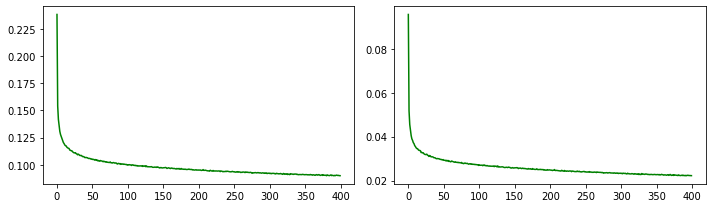

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(history.history['mae'], 'g')
axes[1].plot(history.history['mse'], 'g')
fig.tight_layout()

# Last step

Prepare your model to predict the set of new data to predict, you will have only 6 hours to push your predictions.

(may be you would like to express, when guessing the percentage of wins for blacks, that it should reflect the fact that this score should be the same for all the symmetries you considered)...


In [0]:
def get_raw_data_go_prediction():
    ''' Returns the set of samples from the local file or download it if it does not exists'''
    import gzip, os.path
    import json

    raw_samples_file = "positions-to-evaluate-9x9-attempt.json.gz"

    if not os.path.isfile(raw_samples_file):
        print("File", raw_samples_file, "not found, I am downloading it...", end="")
        import urllib.request 
        urllib.request.urlretrieve ("https://www.labri.fr/perso/lsimon/ia-inge2/positions-to-evaluate-9x9.json.gz", raw_samples_file)
        print(" Done")

    with gzip.open(raw_samples_file) as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

In [0]:
def data_transform_pred(data):
    X = []

    for i in range(len(data)): 
        black_stones = np.zeros((9,9), dtype=np.float32)
        white_stones = np.zeros((9,9), dtype=np.float32)
        player_turn = np.zeros((9,9), dtype=np.float32)
        black = data[i]["black_stones"]
        white = data[i]["white_stones"]
        
        for j in range(len(black)):
            x,y = name_to_coord(black[j])
            black_stones[x,y] = 1
        for j in range(len(white)):
            x,y = name_to_coord(white[j])
            white_stones[x,y] = 1
        if (len(data[i]["list_of_moves"])%2 == 0):
          player_turn = np.ones((9,9), dtype=np.float32)
        img = np.dstack((black_stones,white_stones,player_turn))
        X.append(img)
        
    X_data = np.array(X)
    print(X_data.shape)
    
    return X_data

In [0]:
def create_result_file(newdata):
    ''' Exemple de méthode permettant de générer le fichier de resultats demandés. '''
    y_predicted = model.predict(newdata)
    with open("my_predictions.txt", "w") as f:
         for i in range(len(y_predicted)):
           p = y_predicted[i][0]
           f.write(str(p)+"\n")

In [0]:
data_to_predict = get_raw_data_go_prediction()
x_to_predict = data_transform_pred(data_to_predict)
x_to_predict = x_to_predict.astype('float32')
create_result_file(x_to_predict)

(1000, 9, 9, 3)
